## SOLERwave Event Study Notebook

In [1]:
import matplotlib as mpl
import astropy.units as u
from astropy.coordinates import SkyCoord
import numpy as np
from sunpy.coordinates import frames
import matplotlib.pyplot as plt

from SOLERwaves_custom_file_handler import load_preprocessed_fits,create_folder_structure_result,print_parameter_dict,create_numerical_output
from SOLERwave_find_fit_great_arcs import pixel_to_great_segments,find_segments_from_list_staggered,peak_finding_algorithm,wave_tracing_algorithm
from SOLERwave_plotting_tool import Telescope_Instrument_string,oktant_plot,plot_perturbation_profiles,plot_fit_with_wave_features,plot_timeseries_of_lineplot_and_map

#mpl.use('Qt5Agg') # Python Backend for interactive plots

# Custom Parameters

To use the SOLERwave tool, it needs 5 main user inputs.

1.) The path to the Data folder and the name of the LVL_0_directory, as created by the search_new_event function. The search_new_event function prints both at the end of operation where they can be copied.

2.) The wave origin. It can approximated by the location of the associated flare and found in data banks like https://www.lmsal.com/~nitta/movies/AIA_Waves/

3.) The direction of the wave. Please add those in the section **Defining the Sector of interest**



In [2]:
import requests
from xml.dom.minidom import parseString

base_url = 'https://a3s.fi/msc_course_2025'

r = requests.get(base_url)

doc = parseString(r.content)

vals = doc.getElementsByTagName('ListBucketResult')
vals2 = vals[0].getElementsByTagName('Contents')
files = []
for content in vals2:
    vals3 = content.getElementsByTagName('Key')
    fn = vals3[0].firstChild.nodeValue
    if fn.split('.')[-1] == 'fits':
        files.append(fn)

In [3]:
files[0]

['SOLERwave_2022-03-28T11_14_59-AIA_211AA/Preprocesed_Fits/aia.lev1_euv_12s.2022-03-28T111459Z.211.image_lev1_reference.fits',
 'SOLERwave_2022-03-28T11_14_59-AIA_211AA/Preprocesed_Fits/aia.lev1_euv_12s.2022-03-28T111511Z.211.image_lev1_derot_bin_base.fits',
 'SOLERwave_2022-03-28T11_14_59-AIA_211AA/Preprocesed_Fits/aia.lev1_euv_12s.2022-03-28T111523Z.211.image_lev1_derot_bin_base.fits',
 'SOLERwave_2022-03-28T11_14_59-AIA_211AA/Preprocesed_Fits/aia.lev1_euv_12s.2022-03-28T111535Z.211.image_lev1_derot_bin_base.fits',
 'SOLERwave_2022-03-28T11_14_59-AIA_211AA/Preprocesed_Fits/aia.lev1_euv_12s.2022-03-28T111547Z.211.image_lev1_derot_bin_base.fits',
 'SOLERwave_2022-03-28T11_14_59-AIA_211AA/Preprocesed_Fits/aia.lev1_euv_12s.2022-03-28T111559Z.211.image_lev1_derot_bin_base.fits',
 'SOLERwave_2022-03-28T11_14_59-AIA_211AA/Preprocesed_Fits/aia.lev1_euv_12s.2022-03-28T111611Z.211.image_lev1_derot_bin_base.fits',
 'SOLERwave_2022-03-28T11_14_59-AIA_211AA/Preprocesed_Fits/aia.lev1_euv_12s.2022-

In [ ]:
folders = []
for file in files:
    folders.append(file.split('/')[0])
folders = set(folders)

import os
for i in folders:
    dirname = i + '/Preprocesed_Fits'
    try:
        os.makedirs(dirname)
    except:
        print(f'Directory {dirname} already exists.')

In [32]:
import urllib.request as request
for i in files:
    result=request.urlretrieve(base_url + '/' + i, i)

In [35]:
path = ''

# Event 1
LVL_0_directory = 'SOLERwave_2022-03-28T11_16_59-AIA_211AA_1k_1k'
wave_origin = [15*u.deg,4*u.deg] # [N/S, W/E]

# Event 2
#LVL_0_directory = 'SOLERwave_2024-03-10T12_02_59-AIA_211AA'
#wave_origin = [-13*u.deg,38*u.deg] # [N/S, W/E]

The first part of the tool loads the preprocesed fits files, creates an Astropy object for the wave origen location and derives the azimuthal and radial angle of each pixel on the map with respect to the wave origen vector.

In [36]:
map_data_list,m_base,time,m_seq_base = load_preprocessed_fits(path =path,LVL_0_directory = LVL_0_directory)

# Coordinates Flares
Flare_coordinates = SkyCoord(wave_origin[1],wave_origin[0],obstime=m_base.date,frame=frames.HeliographicStonyhurst).transform_to(m_base.coordinate_frame)
#Flare_coordinates = SkyCoord(Tx = 633.15535152* u.arcsec, Ty = -242.92428763* u.arcsec,frame=m_base.coordinate_frame)

# Find the pixel angles
coords,aangles_along_arc,ttheta = pixel_to_great_segments(Flare_coordinates,m_base)

06:28:16 load_preprocessed_fits: files loaded


# Octant Plot to find wave direction

The octant plot is a powerful quicklook plot to identify potential coronal waves. It includes 8 so-called J-maps in which the propagating wave appears as an oblique line of enhanced emission in the distance-time maps. Each J-map corresponds to a different direction with respect to the great circle intersecting both the wave origen and the solar north.

The plot in the center is the reference image for the base ratio overlaid with the sectors corresponding to the j-map closest to it. (i.e. the north pointing sektor is equivalent to "direction 0 degree")

06:28:53 Octant Plot: finished


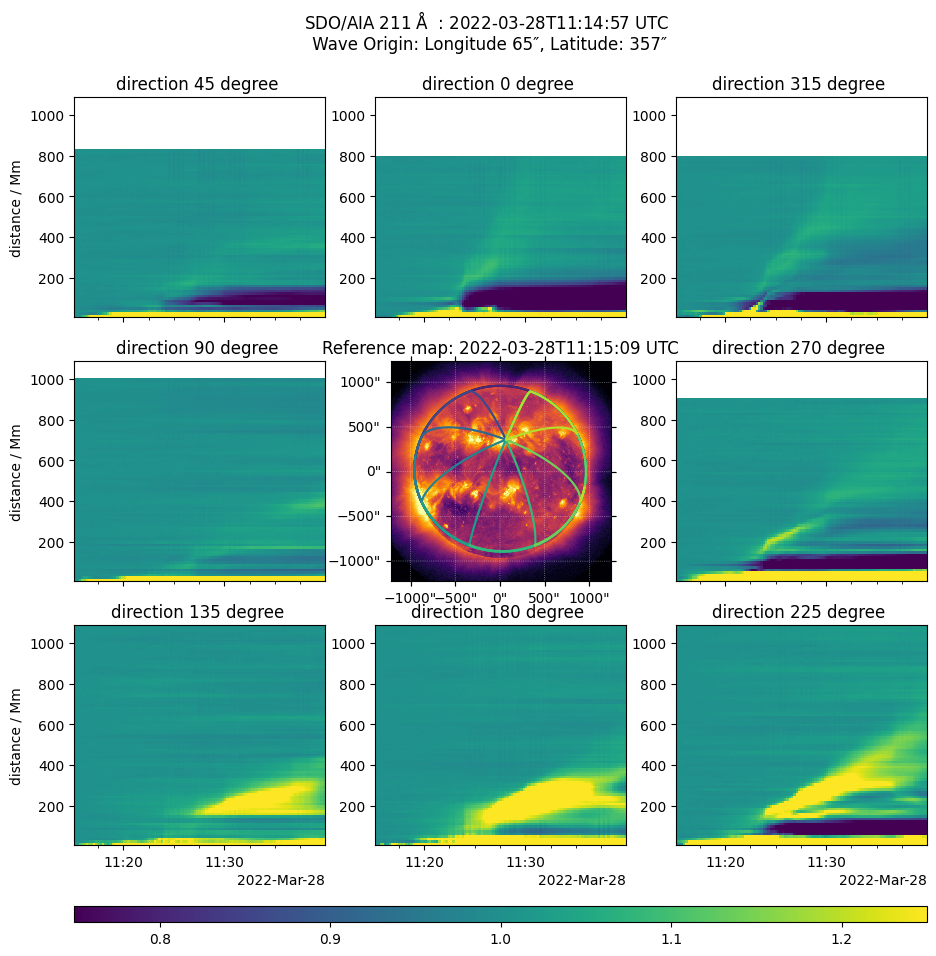

In [37]:
# Calling the Oktant_plot to evaluate the direction of possible waves
oktant_plot(map_data_list,m_base,Flare_coordinates,ttheta,aangles_along_arc,time)

## Defining the Sector of interest

Can the trace of a possible wave be observed in the octant plot, the sector to be investigated further has to be defined.

# angles_along_arc_range
Defines the border of the equidistant circles with respect to the wave origen splitting up the solar surface. 
**! A start distance of 5° and a step size of 1° is recommended** 

# theta_range
Defines the borders of the sector in mathematical positive direction with respect to the great circle intersecting the wave origen and the solar north.
**! A minimum range of 10° is recommended for good statistics**

In [38]:
angles_along_arc_range = np.arange(start = 5,stop = 60,step=1) *np.pi/180
theta_range = np.array([ 0 , 20])*np.pi/180 


Calculation of perturbation profiles of the sector and fining of the peaks in each.

The parameters in the functions are set to work with most EUV waves. Should problems still arise, flowing steps can be taken:

- Very complex waves might have more than 6 peaks of interest per perturbation profile. Increasing max_nr_peaks_const can solve this problem.
- Very weak waves might not be able to trigger the minimum peak levels. Decreasing min_peak_height and c_closest can help in this case. c_closets is the minimum required height in percent between a peak and its deepest surrounding vally >= 1.

In [39]:
# All functions use a "j" - index to allow the calculation of multiple sectors in one script (each sector indexed by a different "theta angle index" j).  
# Set to 0 in this example as only 1 sector is investigated
j = 0 
parameter_dict = {}

if theta_range[j] < theta_range[j+1]:
    direction = ((theta_range[j] + theta_range[j + 1]) / 2 * 180 / np.pi) % 360
    width = ((theta_range[j+1] - theta_range[j]) * 180 / np.pi) % 360
elif theta_range[j] > theta_range[j+1]:
    direction = (180-(theta_range[j] + theta_range[j+1])/2 * 180 / np.pi) % 360
    width = (360 - (theta_range[j] - theta_range[j+1]) * 180 / np.pi) % 360

# Labels for the plots
str_direct_width = ' Dir.: %.1f°, Width: %.1f°' % (direction, width)

instr_title_string = Telescope_Instrument_string(m_base)
instr_dir_width_title_string = instr_title_string + str_direct_width


file_path_dict = create_folder_structure_result(path =path, LVL_0_directory = LVL_0_directory,
                                                wave_origin_coordinates=Flare_coordinates, direction=direction, width=width)

intensity_mean,intensity_var,distance,mask_3,pixel_per_segment,parameter_dict = find_segments_from_list_staggered(theta_range,ttheta,angles_along_arc_range,aangles_along_arc,map_data_list,times_staggered = 4,parameter_dict = parameter_dict)


d_peak_mat,d_front_mat,d_trail_mat,peak_mat,front_mat,trail_mat,delta_peak_mat,t_sunpy_sec,max_nr_peaks_vec,max_nr_peaks_const,parameter_dict = peak_finding_algorithm(intensity_mean,np.sqrt(intensity_var),theta_range,distance,time,max_nr_peaks_const = 6,wavefront_cutof = 0.5,min_peak_height = 1.03,c_closest=0.03,parameter_dict = parameter_dict)


06:29:22 create_folder_structure_result: folder successfully created


## Plotting perturbation profiles

The following cell plots the oktant_plot again, this time saving in results folder of the investigation. 

It further plots the perturbation profiles along the sector for each time sector. Each plot holds up to 20 time steps, a new plot is created should there be more time steps in the time series. These are saved in the diagnostics folder.

06:29:53 Octant Plot: finished
06:30:01 Plot_pertubation_profiles: finished


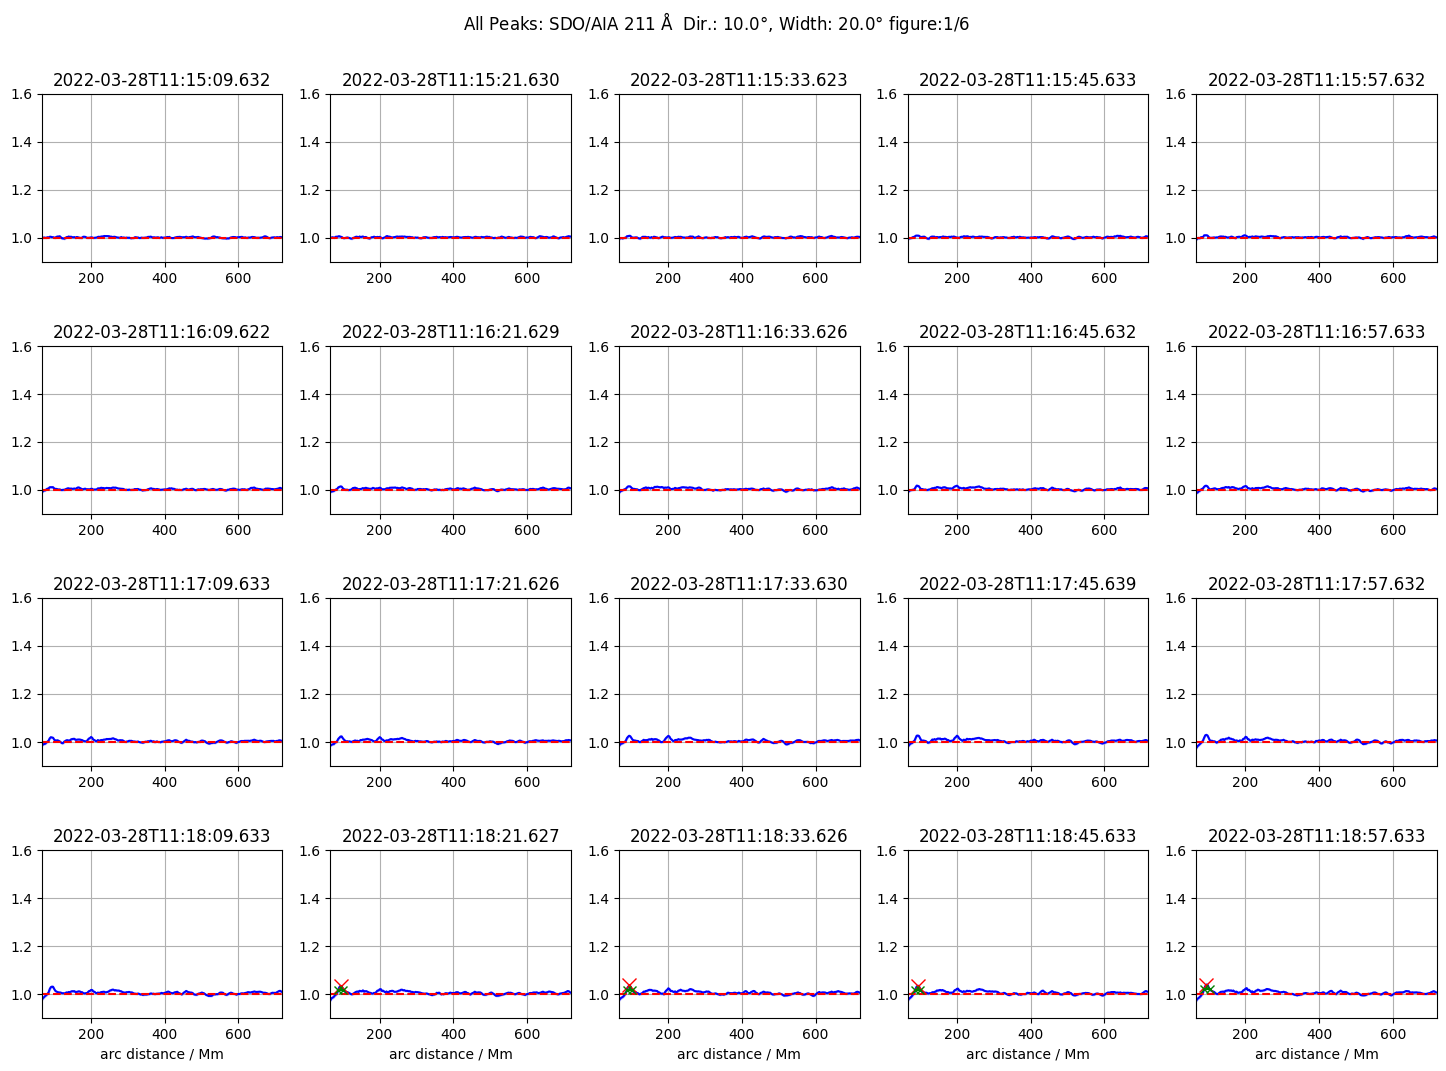

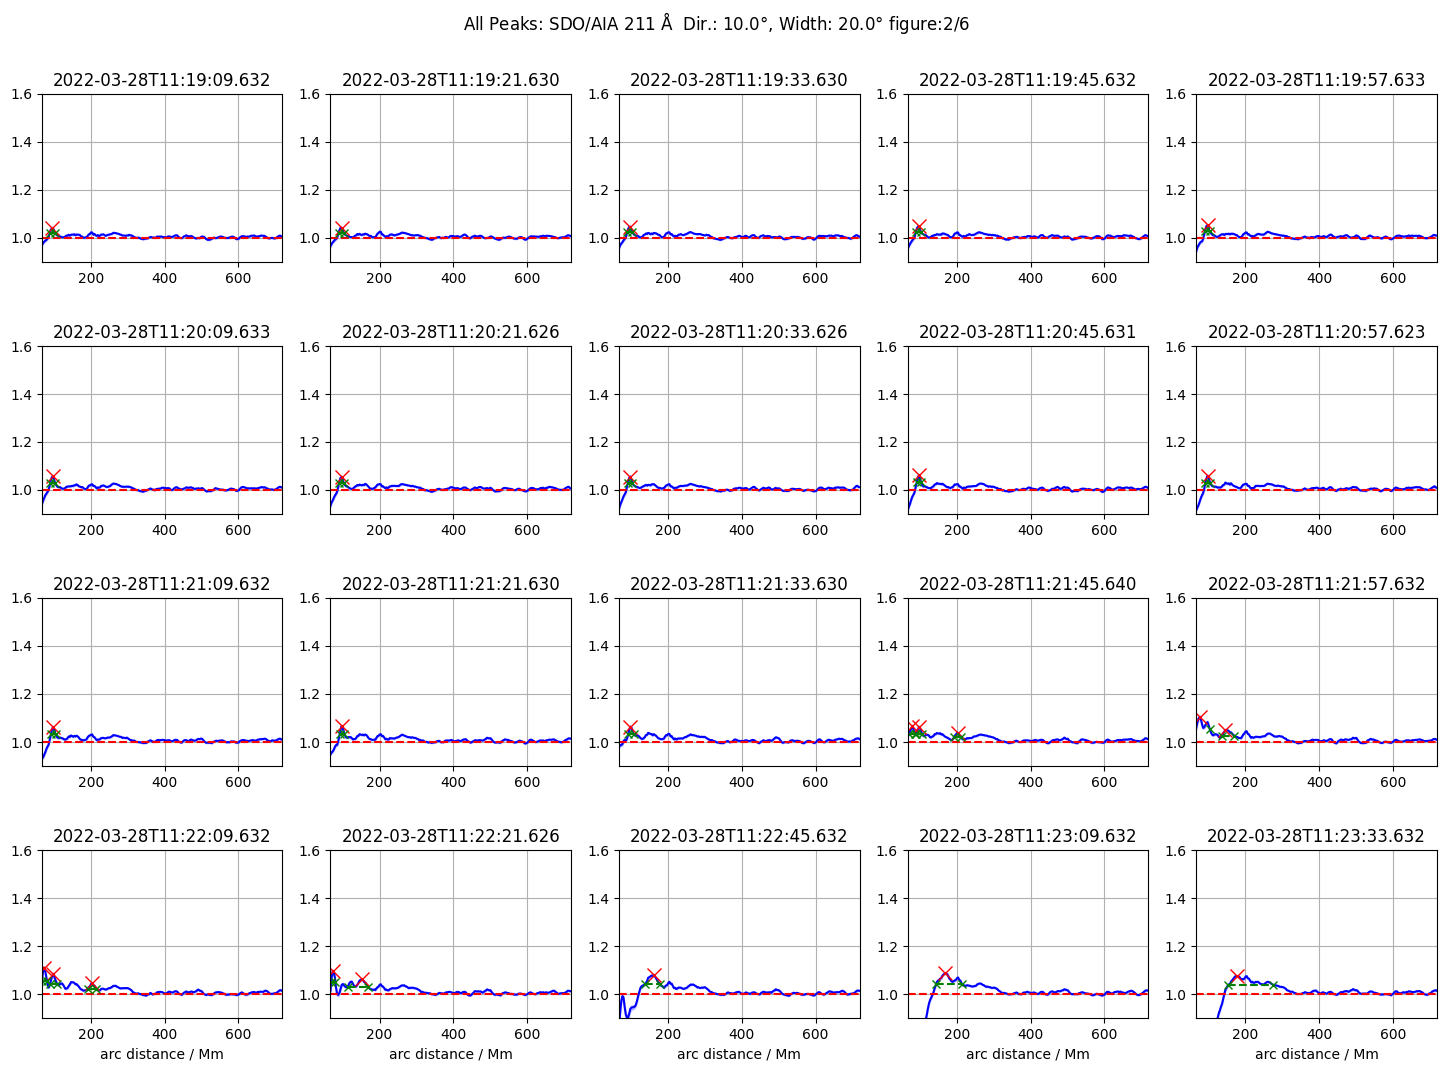

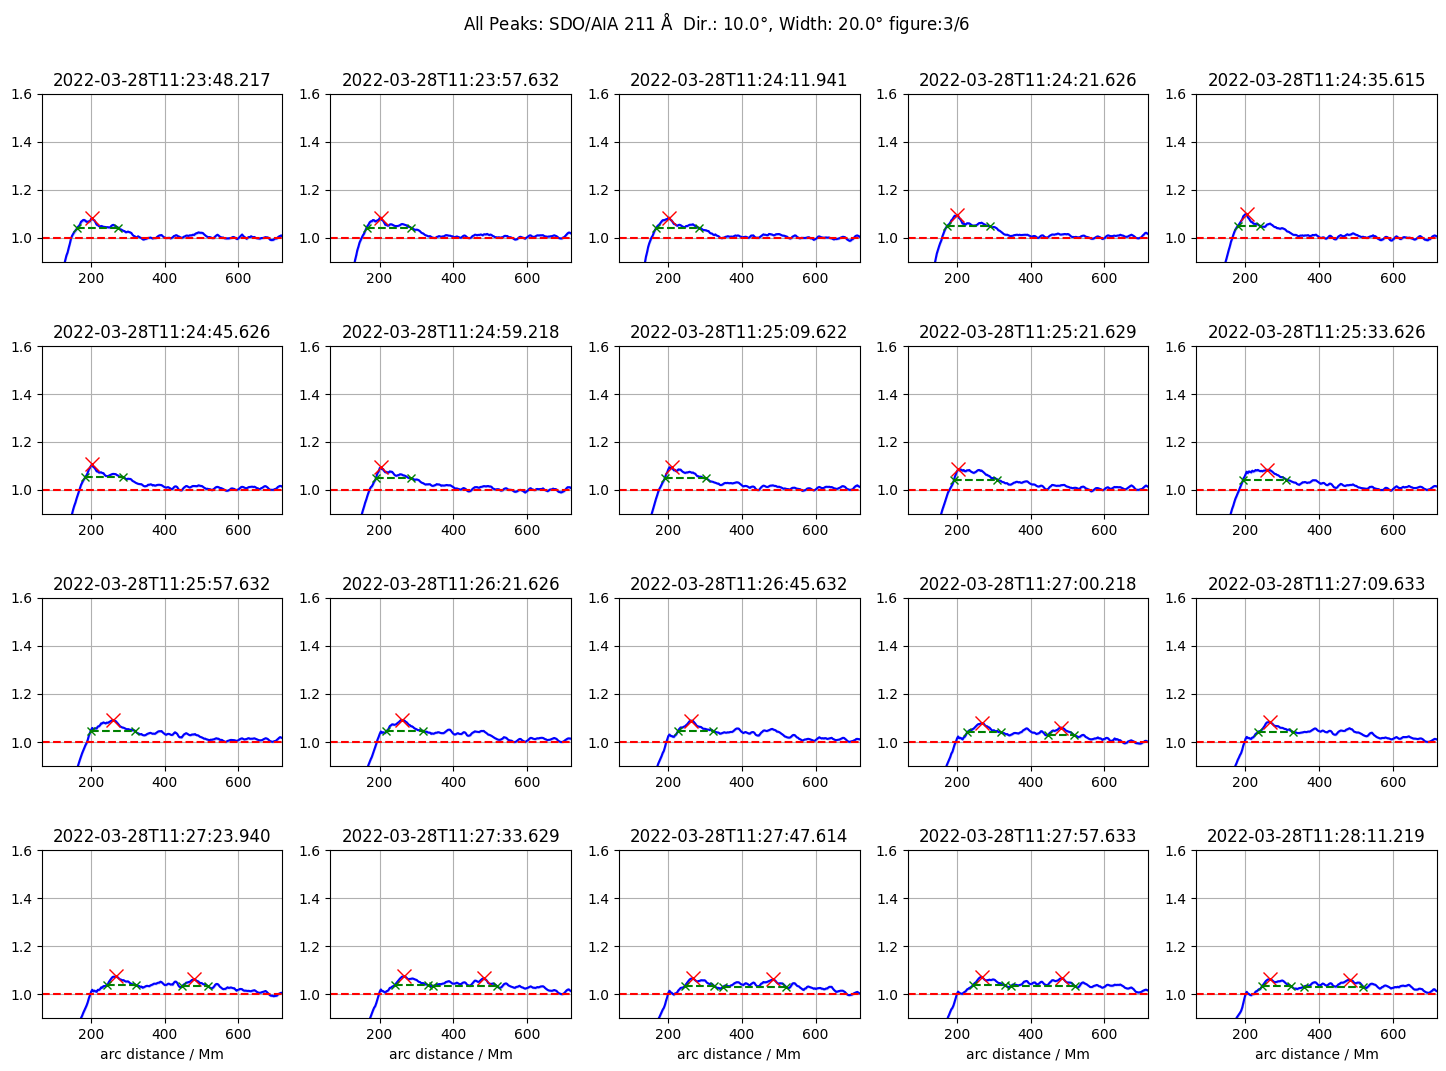

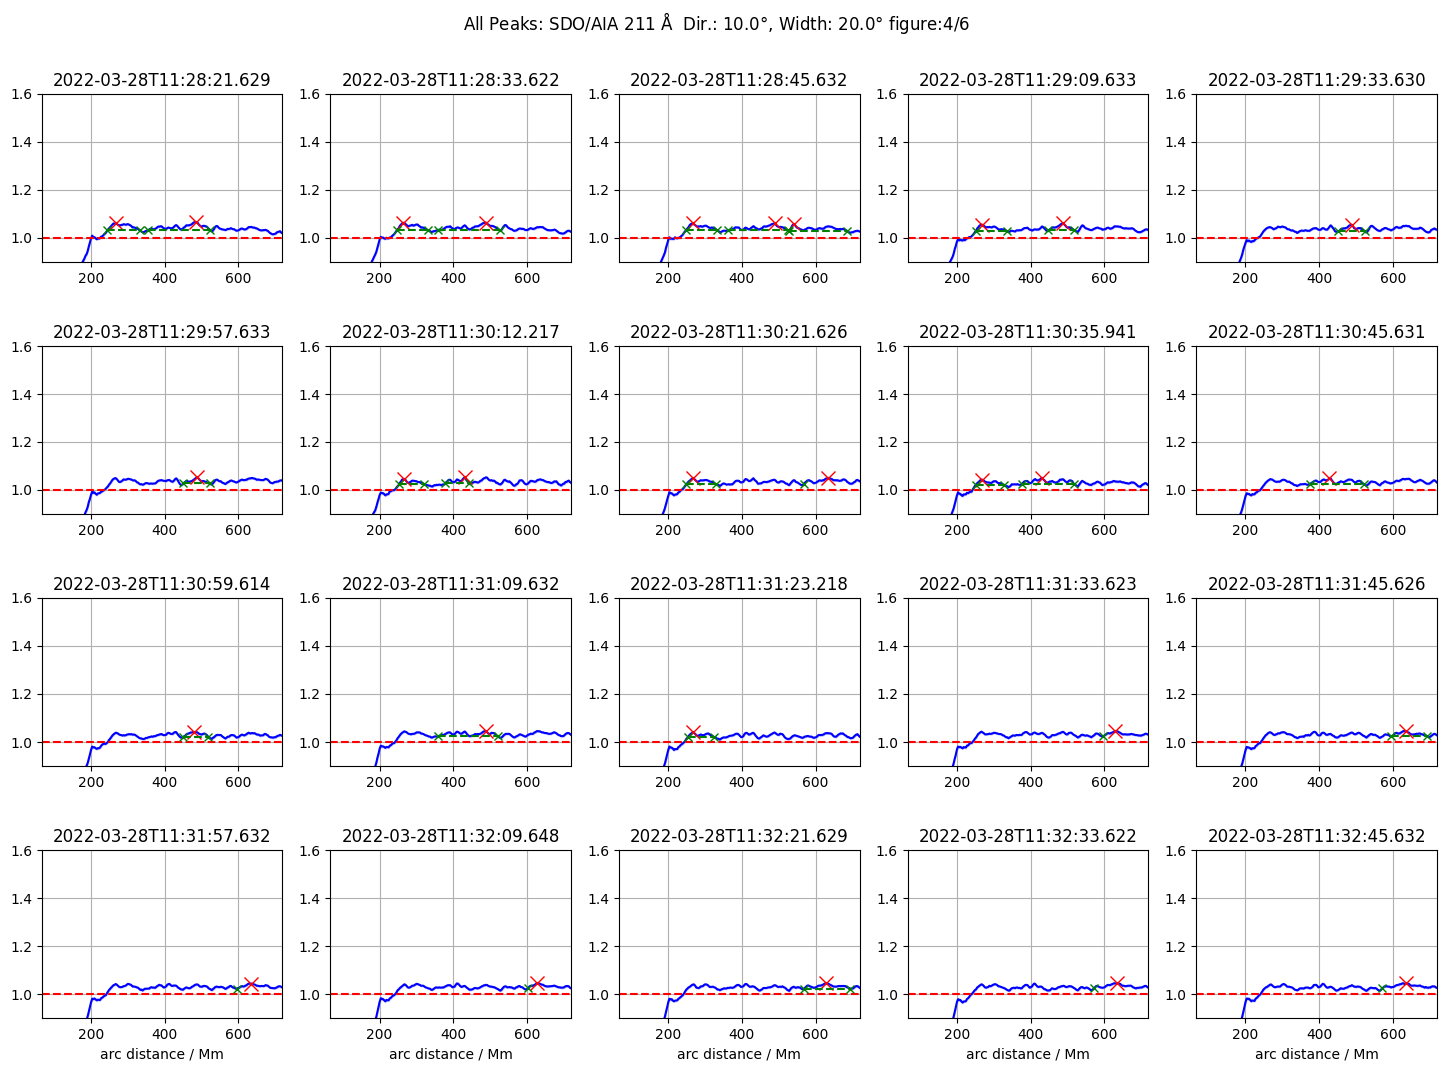

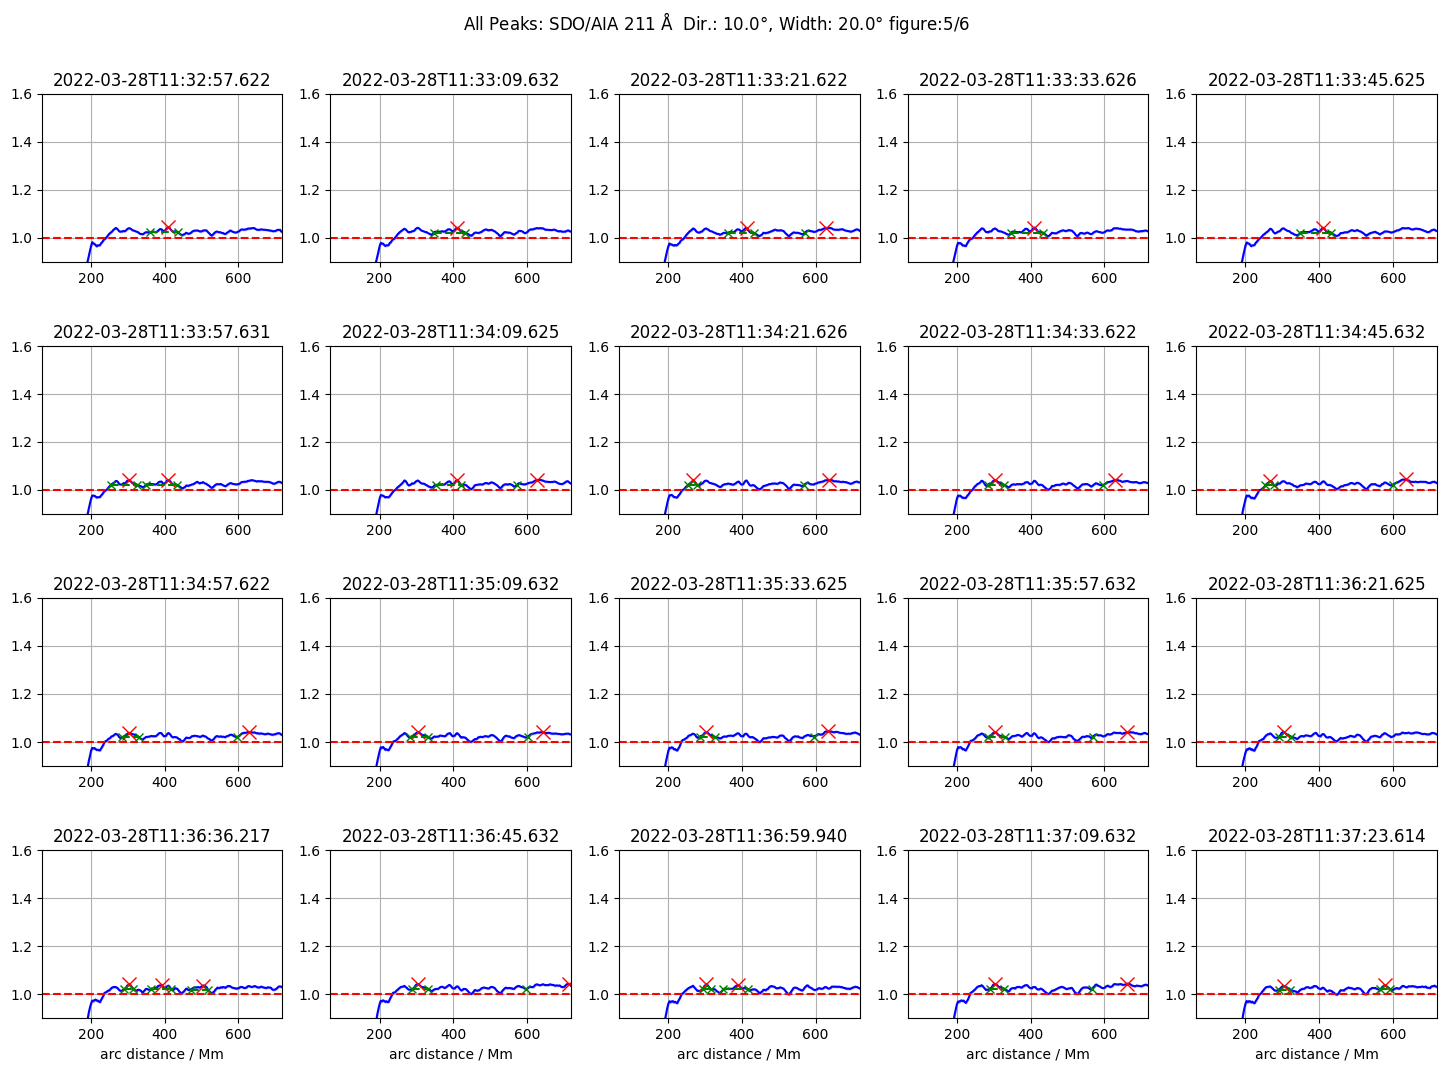

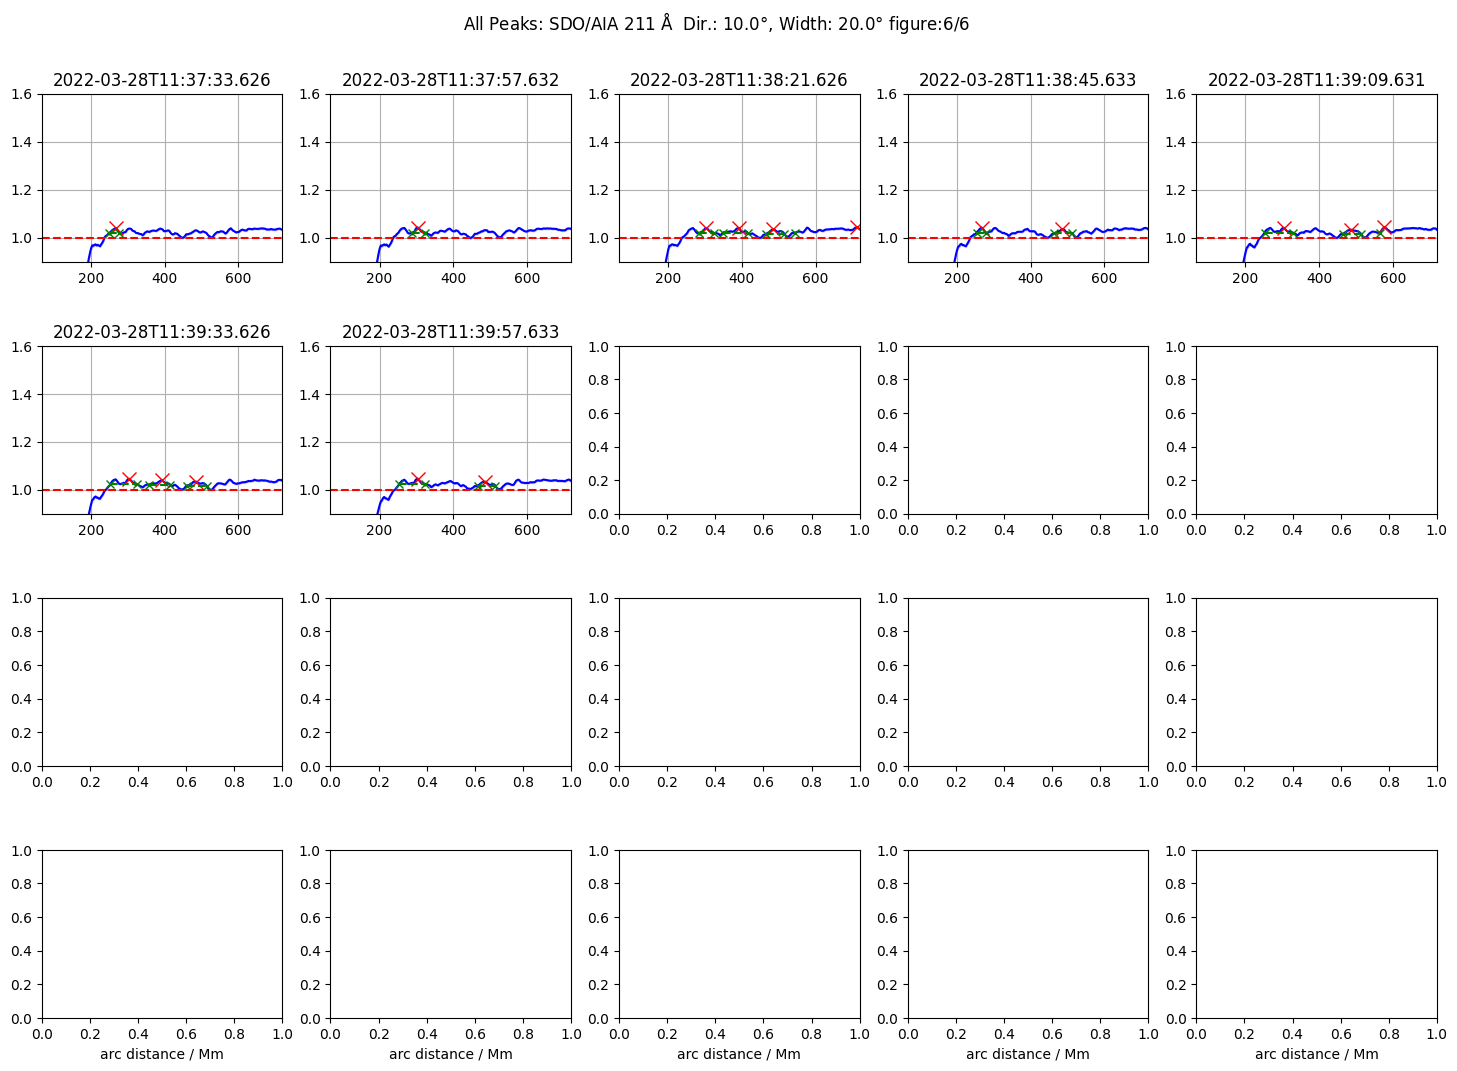

In [40]:
oktant_plot(map_data_list,m_base,Flare_coordinates,ttheta,aangles_along_arc,time,file_path_dict = file_path_dict)
plt.close()

plot_perturbation_profiles(distance, intensity_mean, intensity_var, d_peak_mat, d_trail_mat, d_front_mat, peak_mat, trail_mat, front_mat, time, instr_dir_width_title_string = instr_dir_width_title_string, segment_nr = j,show_all_peaks = True, file_path_dict = file_path_dict)

In [ ]:
del map_data_list # To free up RAM

## Wave tracing and wave kinematic plot

The wave tracing algorithm takes the peaks found by the peak finding algorithm and compares them in order to find moving features likely linked to waves.

The results are plotted in two plots. One, showing only the identified waves and the corresponding peaks, and one showing all found peaks as a diagnostics plot.

06:30:13 Plotting_tools: fit_waves_with_subplots finished
06:30:16 Plotting_tools: fit_waves_with_subplots finished
06:30:23 Plot_pertubation_profiles: finished


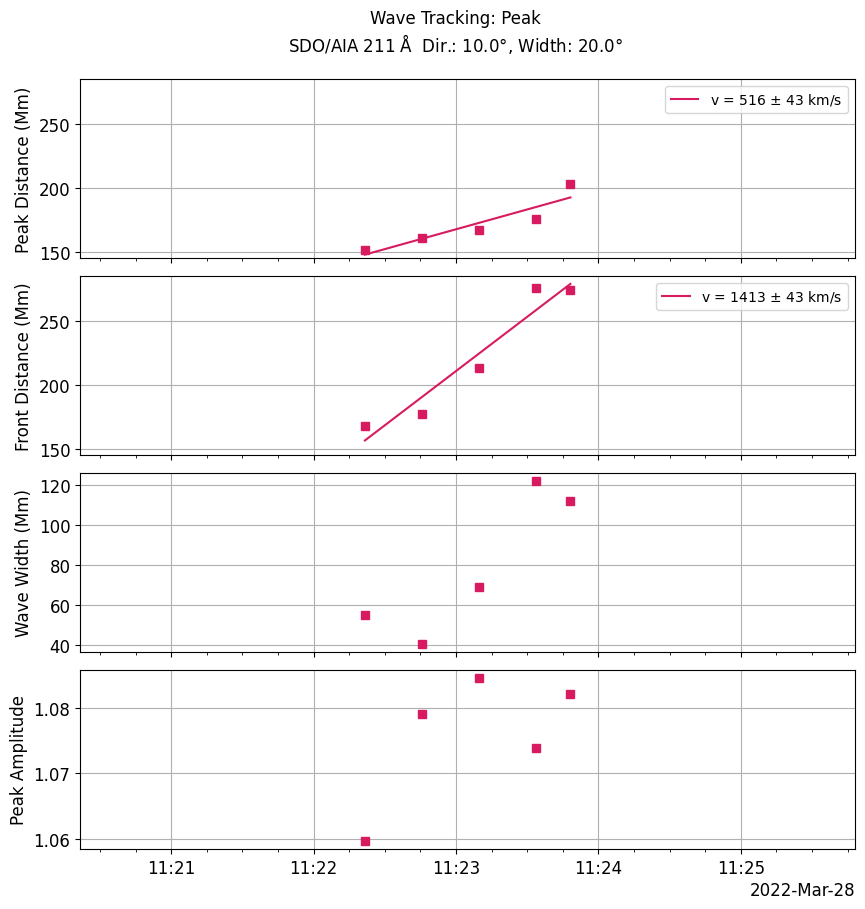

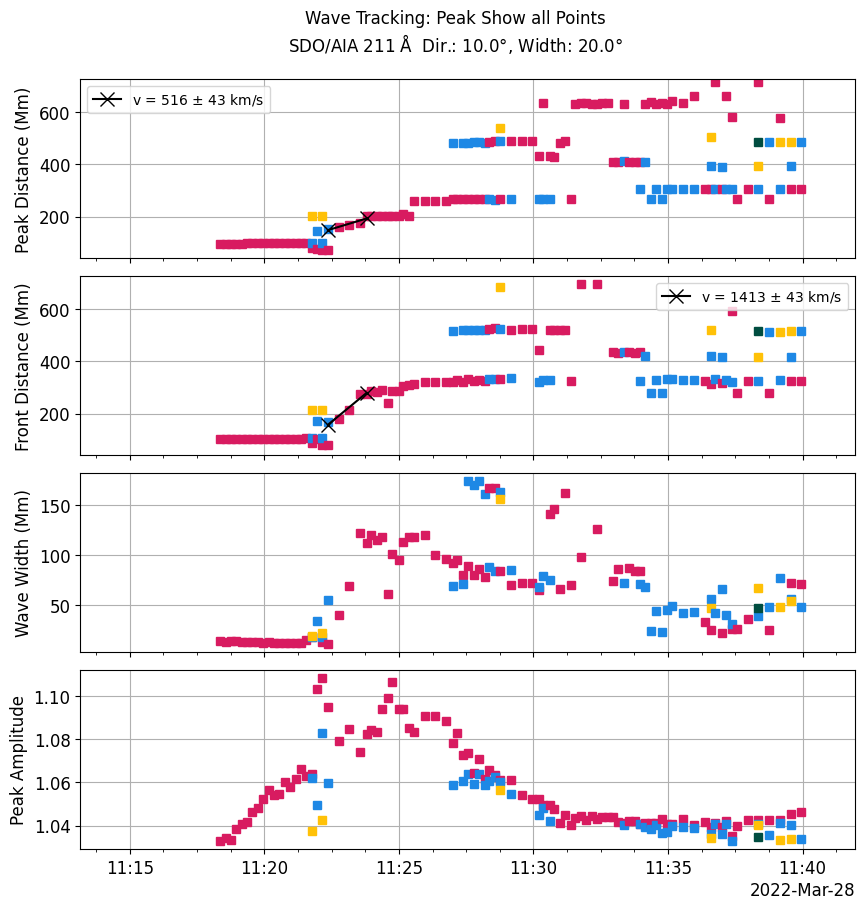

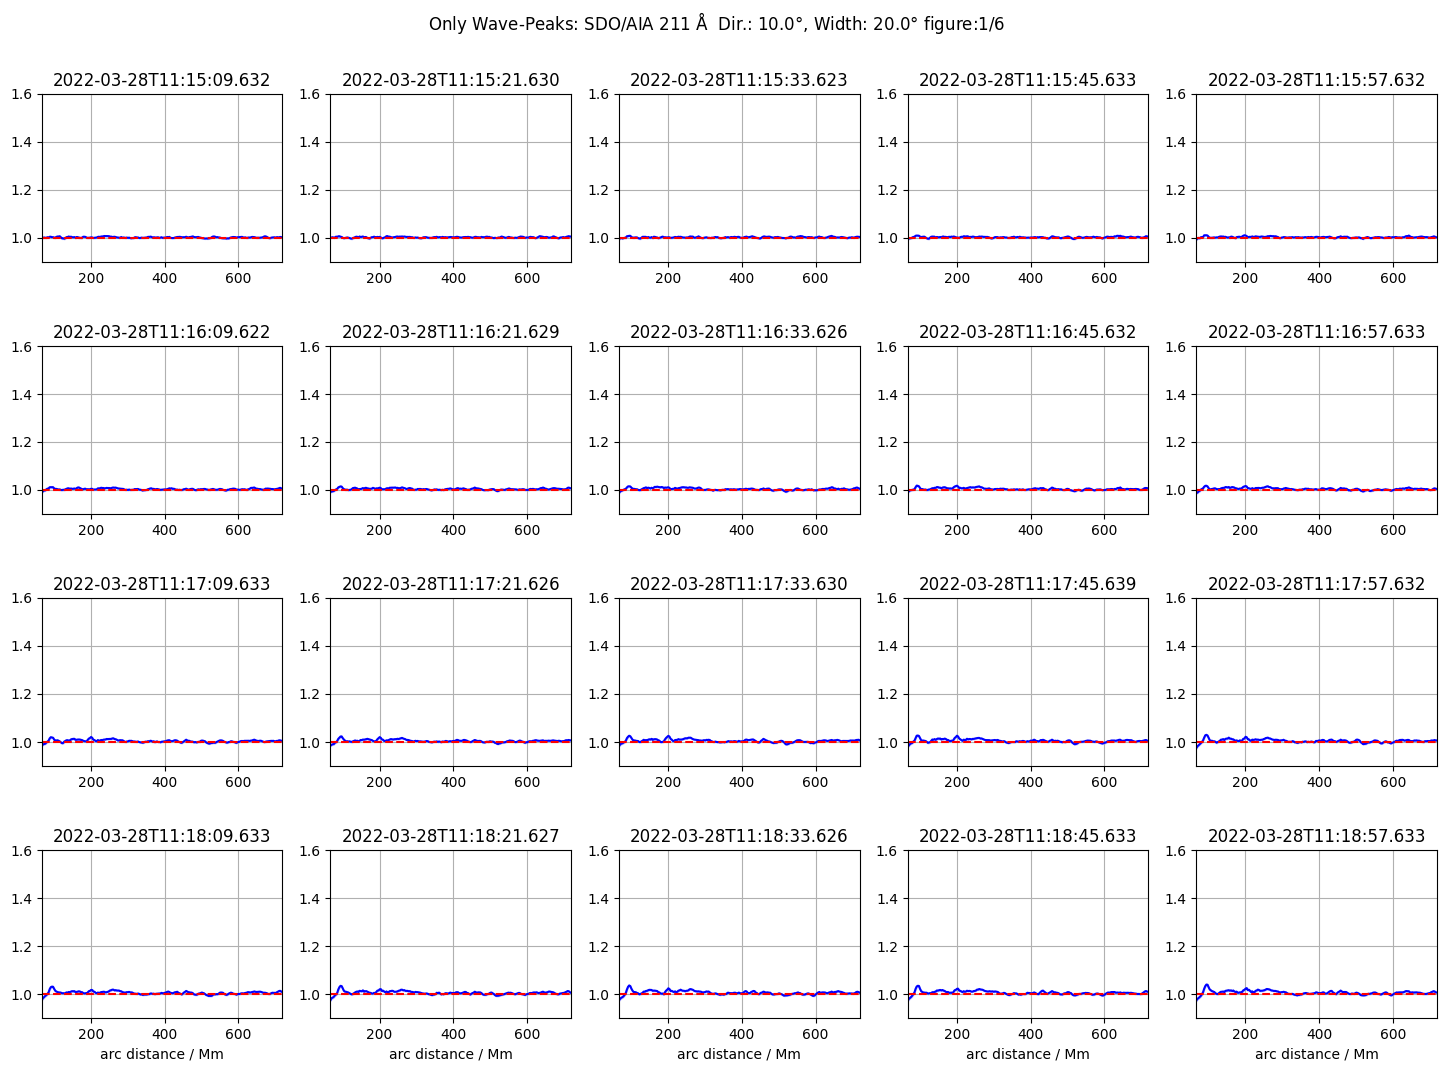

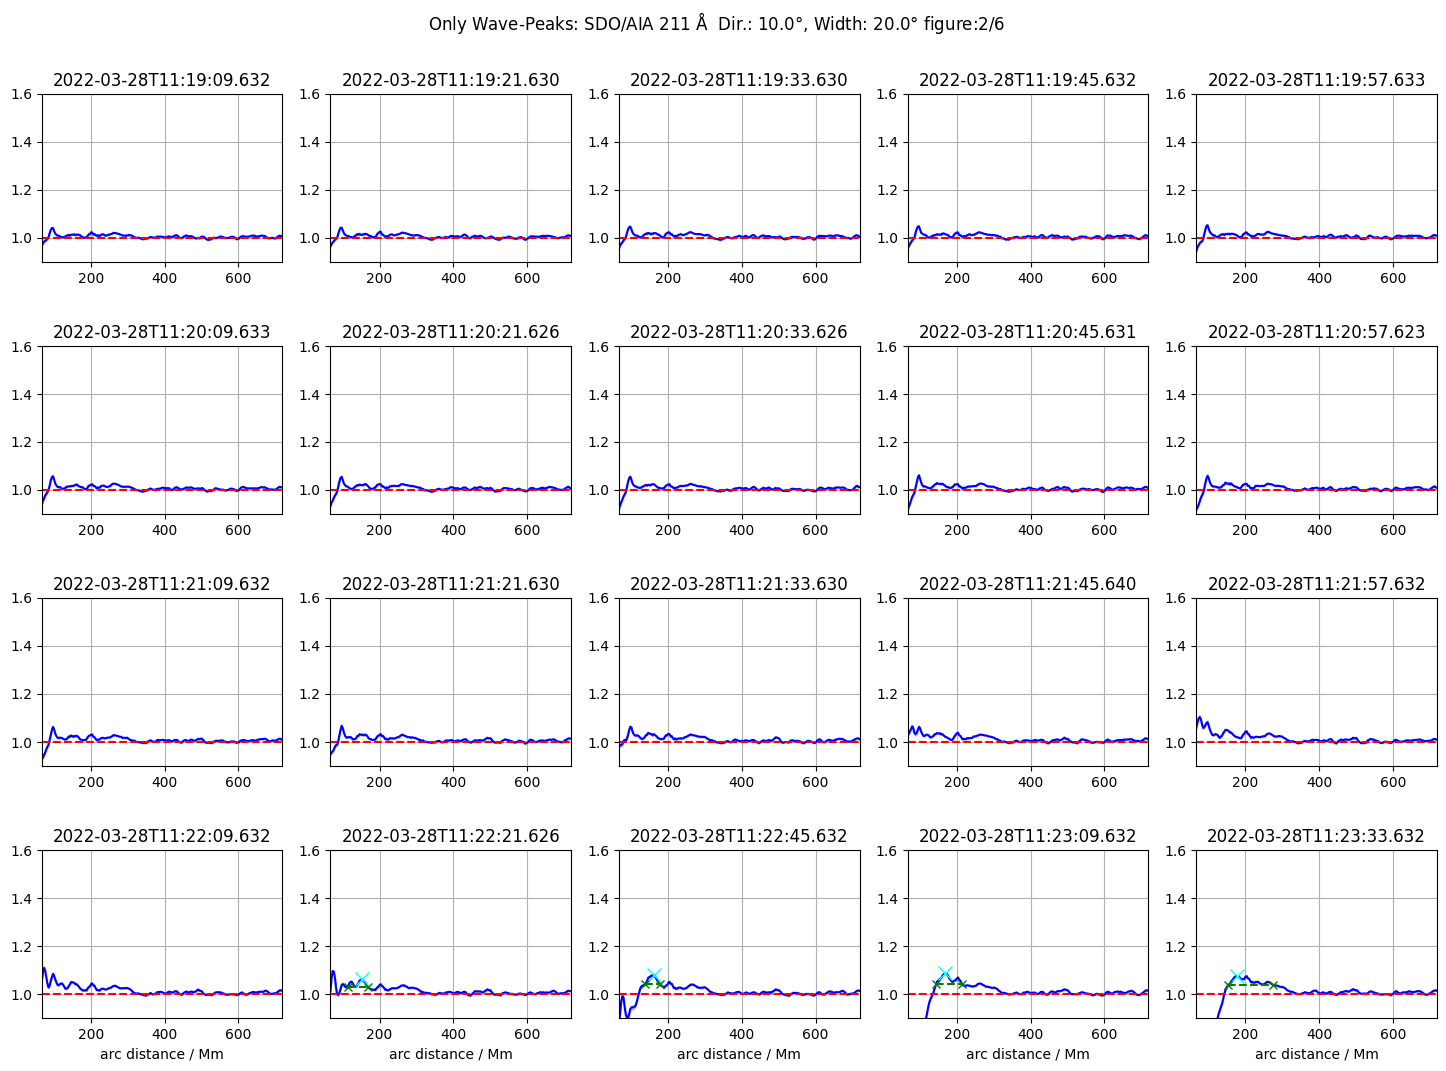

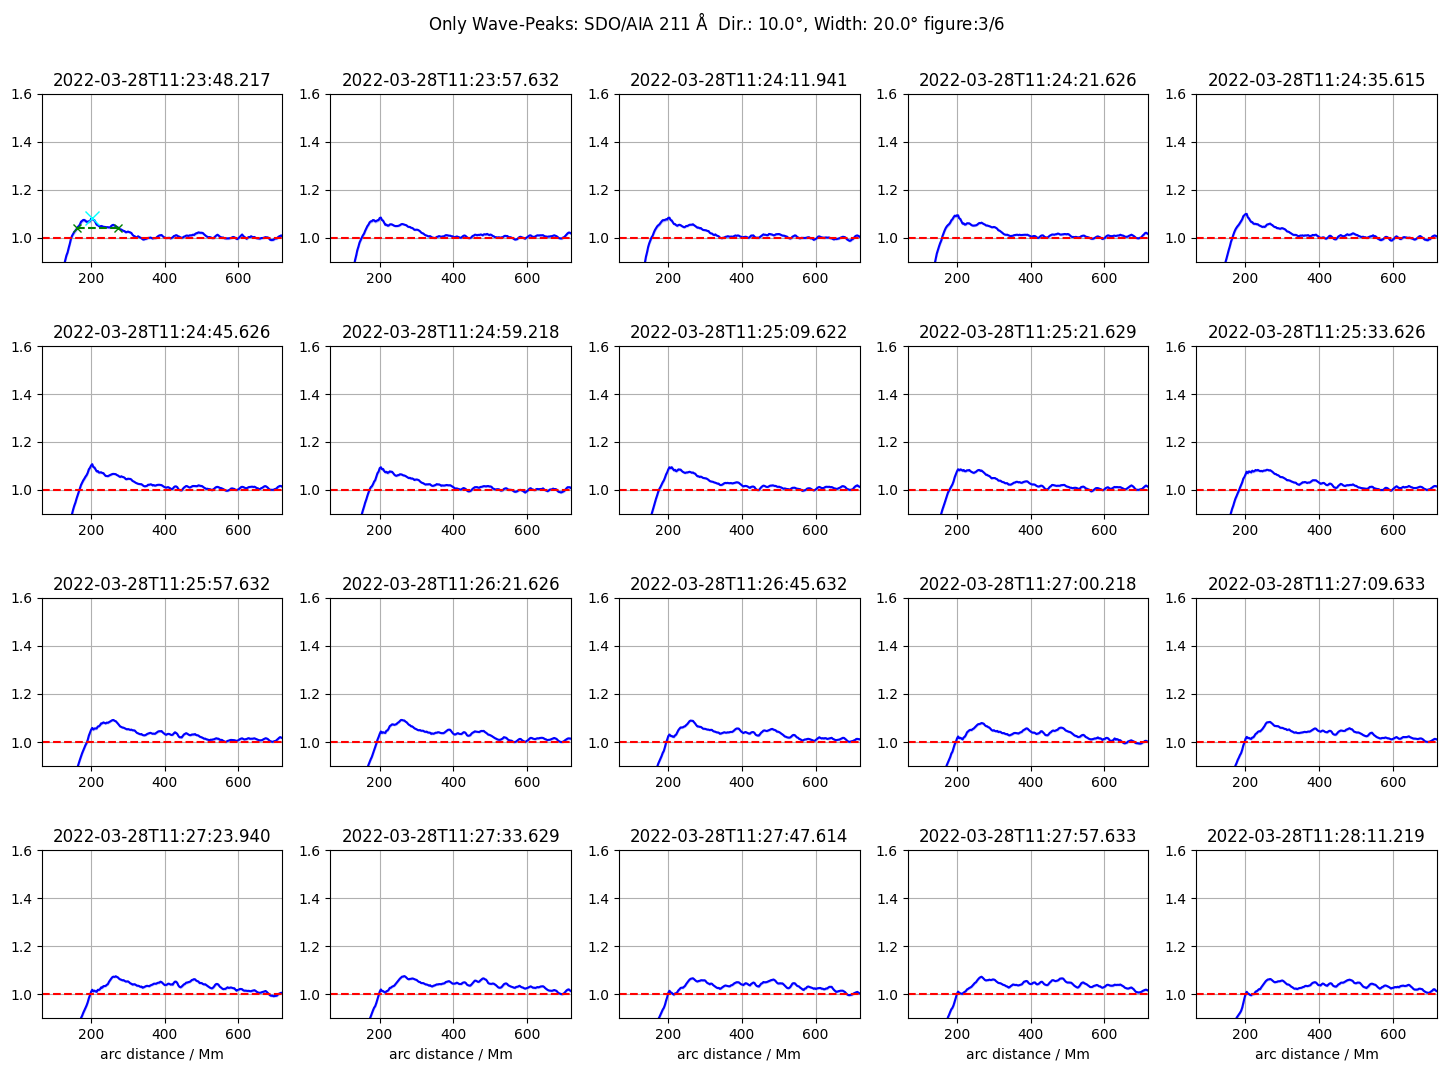

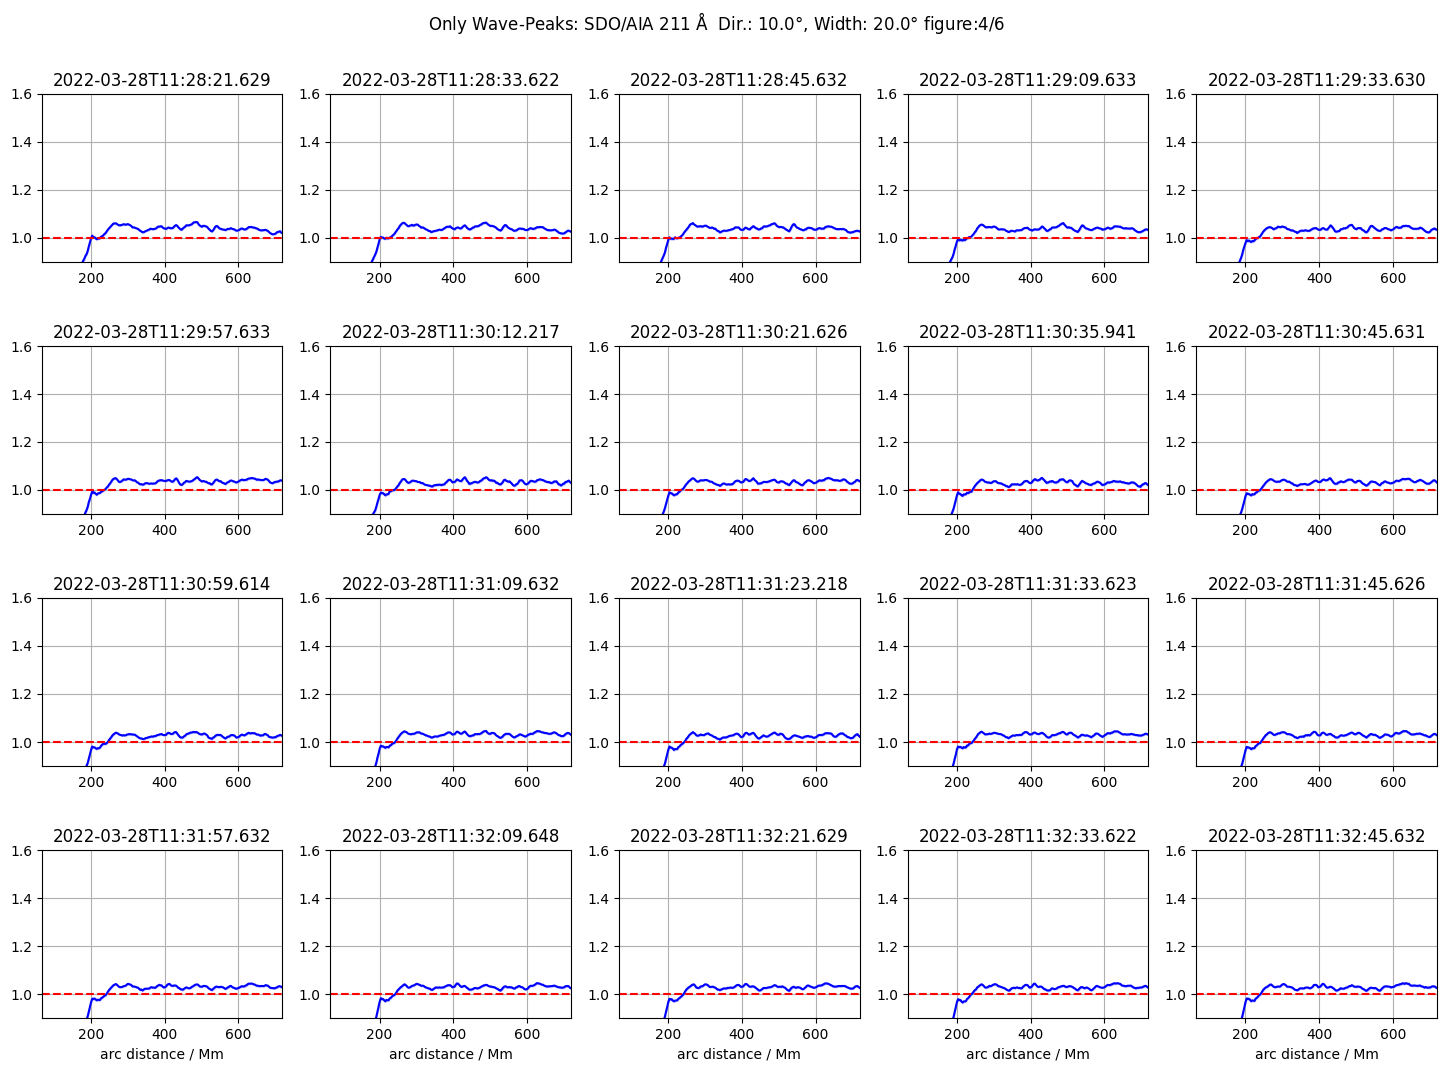

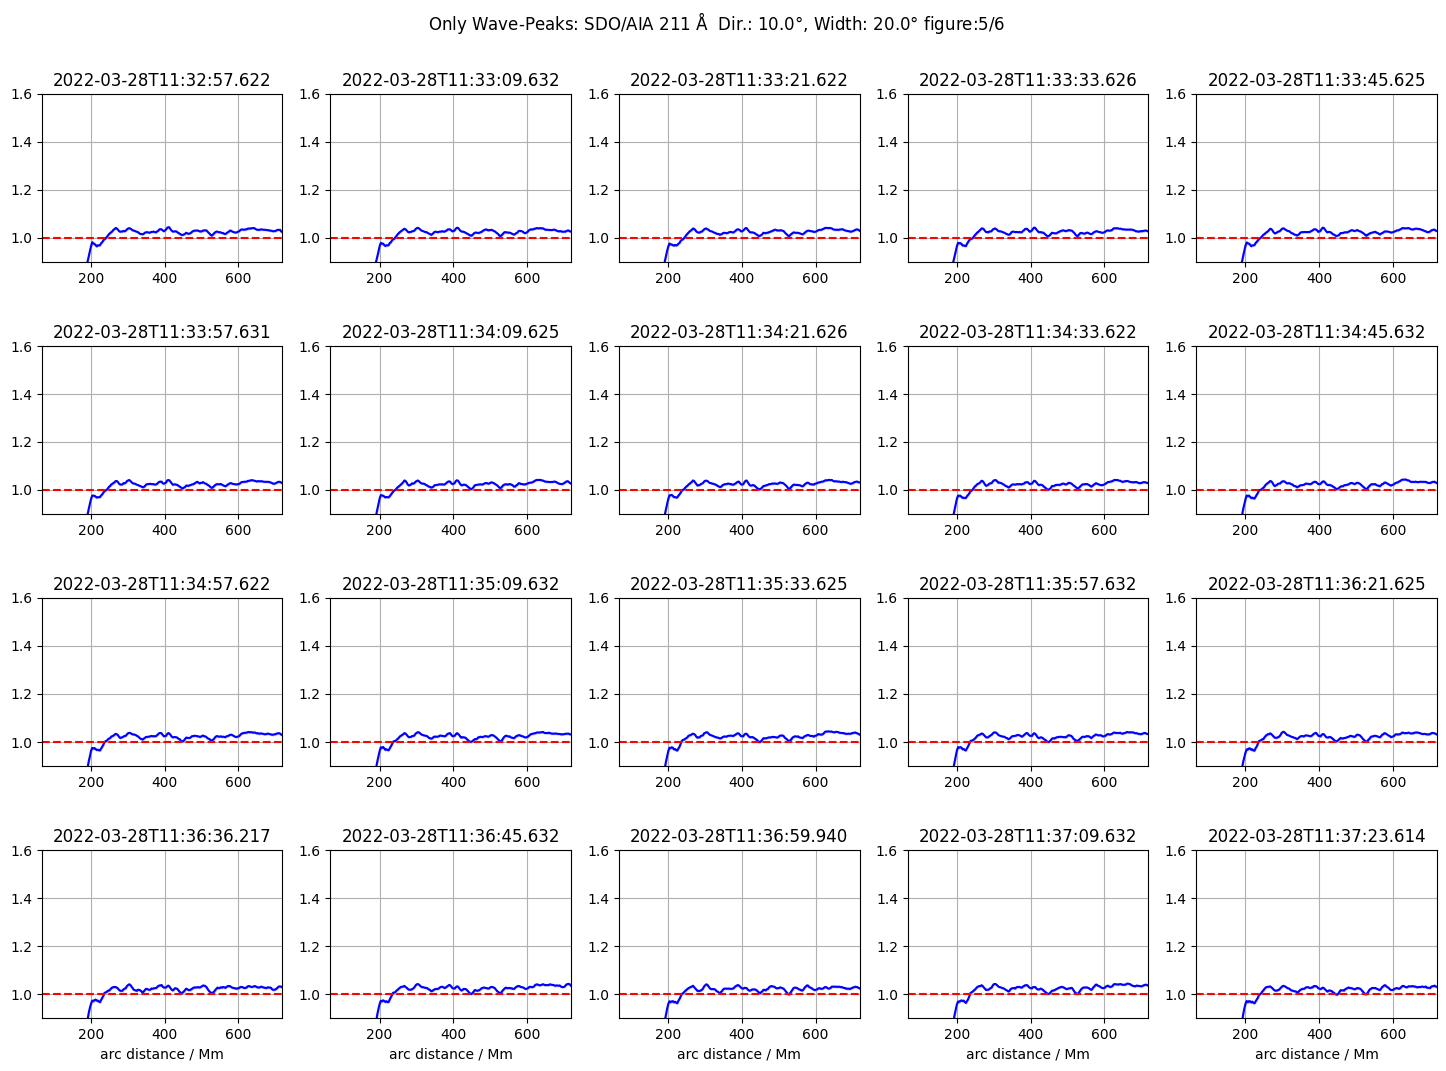

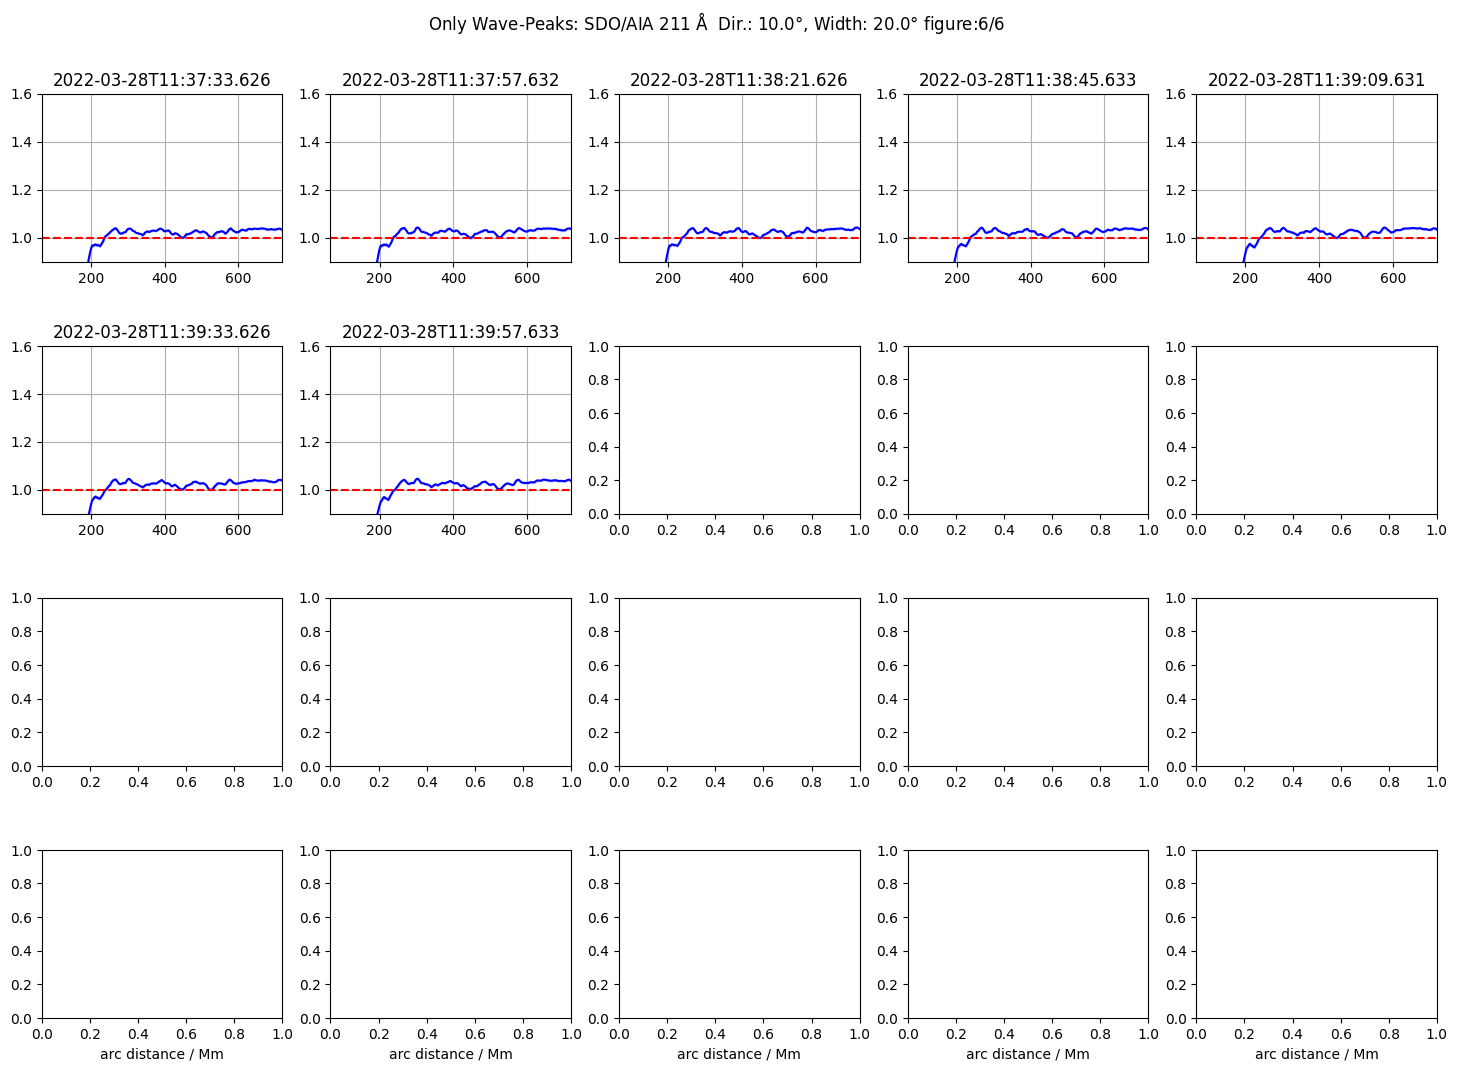

In [41]:
distance_MM = distance.value / 1e6
diff_distance_MM = (distance_MM[1] - distance_MM[0])

wave_value_dict,parameter_dict = wave_tracing_algorithm(d_peak_mat, np.ones_like(d_peak_mat) * diff_distance_MM, t_sunpy_sec,
                                        max_nr_peaks_vec,v_min_step=80,v_max_step=2500,peak_tracked = True,
                                         fit_second_feature = True,d_feature2_mat=d_front_mat,d_feature2_std_mat =np.ones_like(d_front_mat) * diff_distance_MM,parameter_dict = parameter_dict)

parameter_dict = plot_fit_with_wave_features( time, d_peak_mat, d_front_mat, d_trail_mat, peak_mat, distance=distance, instr_dir_width_title_string =instr_dir_width_title_string,
                                             v_min_fit = 100, v_max_fit = 2000, show_all_points = False, file_path_dict=file_path_dict, parameter_dict = parameter_dict, **wave_value_dict)

parameter_dict = plot_fit_with_wave_features( time, d_peak_mat, d_front_mat, d_trail_mat, peak_mat, distance= distance, instr_dir_width_title_string =instr_dir_width_title_string,
                                             v_min_fit = 100, v_max_fit = 2000, show_all_points = True, file_path_dict=file_path_dict, parameter_dict = parameter_dict, **wave_value_dict)

plot_perturbation_profiles(distance, intensity_mean, intensity_var, d_peak_mat, d_trail_mat, d_front_mat, peak_mat,
                           trail_mat, front_mat, time, instr_dir_width_title_string = instr_dir_width_title_string,
                           segment_nr = j, file_path_dict = file_path_dict,show_all_peaks=False, wave_ind_mat_2=wave_value_dict['wave_ind_mat_2'])

## Kinematics Movie

The plot_timeseries_of_lineplot_and_map function produces the frames of a movie of both the perturbation profile and base ratio image overlaid with the sector and links them to a movie. This might take some time, progress bars are implemented to estimate the time needed. The movies can be found in the Results folder of the investigation.

Note: Change the parameter lower_Tx_lim, lower_Ty_lim and Tx_Ty_range to adjust the segment shown in the video. All values are in arcsec. 

In [ ]:
wave_peak_kwargs_vid = {'d_peak_mat':d_peak_mat[:,:,:],'d_front_mat':d_front_mat[:,:,:],'theta_range':theta_range,'peak_mat':peak_mat,'front_mat':front_mat,'Flare_coordinates':Flare_coordinates,'wave_ind_mat_2':wave_value_dict['wave_ind_mat_2']}
segment_kwargs_vid = {'mask_3':mask_3, 'angles_along_arc_range':angles_along_arc_range}


plot_timeseries_of_lineplot_and_map(segment_nr=j, theta_range = theta_range, map_series = m_seq_base, m_base = m_base, intensity_mean = intensity_mean, intensity_var = intensity_var,
                                    time = time, distance = distance, str_direct_width = str_direct_width, lower_Tx_lim=-400, lower_Ty_lim=-400, Tx_Ty_range=1400, linplot_ylim = [0.9,1.6],
                                    wave_peak_kwargs = wave_peak_kwargs_vid, segment_kwargs = segment_kwargs_vid, plot_wavepeak=True, plot_peaks=False,
                                    plot_sector=True, scale_max = 2, scale_min = 0, file_path_dict = file_path_dict)


#plot_timeseries_of_lineplot_and_map(segment_nr=j, theta_range = theta_range, map_series = m_seq_base, m_base = m_base, intensity_mean = intensity_mean, intensity_var = intensity_var,
#                                    time = time, distance = distance, str_direct_width = str_direct_width, lower_Tx_lim=-400, lower_Ty_lim=-400, Tx_Ty_range=1400, linplot_ylim = [0.9,1.6],
#                                    wave_peak_kwargs = wave_peak_kwargs_vid, segment_kwargs = segment_kwargs_vid, plot_wavepeak=True, plot_peaks=True,
#                                    plot_sector=True, scale_max = 2, scale_min = 0, file_path_dict = file_path_dict)


06:30:35 plot_timeseries_of_lineplot_and_map: Frames for Movie ::  12%|█▏        | 13/107 [00:40<04:50,  3.09s/it]

## Numerical output

The following function save the numerical output of the investigation and the dictionary with the main parameters used in the different functions. This shall allow reproduction of results.

In [ ]:
print_parameter_dict(parameter_dict,file_path_dict = file_path_dict)


create_numerical_output(j,
                        intensity_mean, intensity_var, distance,
                        d_peak_mat, d_front_mat, d_trail_mat, peak_mat, front_mat, trail_mat, delta_peak_mat, time,
                        instr_dir_width_title_string,
                        wave_value_dict, file_path_dict=file_path_dict)